In [1]:
import matplotlib
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
import os
import random
import pandas as pd
# from scipy import ndimage
# from skimage.util import img_as_ubyte
import time
from scipy.spatial.distance import cdist
from scipy.linalg import norm

from proglearn.sims.gaussian_sim import _generate_2d_rotation
from proglearn.forest import LifelongClassificationForest
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer
from proglearn.voters import TreeClassificationVoter

# from skimage.transform import rotate
from multiprocessing import Pool
from functools import partial
import ot
from sklearn.neighbors import BallTree
import SimpleITK as sitk
from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes

In [2]:
context = sns.plotting_context(context="poster", font_scale=1)
sns.set_context(context)

In [3]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

In [4]:
def vote_to_pred(vote, test_task, test_grid):
    tree = BallTree(test_grid)
    pred = np.zeros(test_task.shape)
    ind = tree.query(test_task.reshape(-1,2), k=1, return_distance=False)
    for i in range(len(test_task)):
        pred[i,0] = vote[ind[i]]
        pred[i,1] = 1 - pred[i,0]
        
    return pred

In [5]:
def reshape_posteriors(inside, task):
    inside_ravel = inside.ravel()
    preds = np.zeros(inside_ravel.shape)
    j = 0
    for i in range(len(inside_ravel)):
        if inside_ravel[i]:
            preds[i] = task[j]
            j += 1
    preds = preds.reshape(inside.shape)
    
    return preds

In [6]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [7]:
def init_forest(max_depth, n_cls):
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(n_cls)}
    l2f = ProgressiveLearner(default_transformer_class = default_transformer_class,
            default_transformer_kwargs = default_transformer_kwargs,
            default_voter_class = default_voter_class,
            default_voter_kwargs = default_voter_kwargs,
            default_decider_class = default_decider_class,
            default_decider_kwargs = default_decider_kwargs)
    return l2f

In [8]:
def get_random_pt(xlim_, ylim_):
    x = random.uniform(xlim_[0], xlim_[1])
    y = random.uniform(ylim_[0], ylim_[1])
    return x,y

def generate_rand_ellipse(n_sample):
    task_n_sample = n_sample / 2
    data = []
    label = []
    max_ite = 10000
    # make 2 elliptical rings defined by 3 ellipses
    # arbitrarily define the out-most one to be x^2/6^2 + y^2/3^2 = 1
    xlim_ = [-6,6]
    ylim_ = [-3,3]
    ite = 0
    # arbitrarily determine the width of the outer elliptical ring to be 1
    # then need to calculate the width of the inner ring in order to
    # keep the areas of the 2 rings to be the same
    # 5*2\pi - (6*3\pi - 5*2\pi) = 2\pi --> (5-x)(2-x) = 2
    width = np.roots([1,-7,8])[1]  # width of the inner ring
    # make sure there are the same number of data points in each ring/task
    while (label.count(0) < task_n_sample) or (label.count(1) < task_n_sample):
        if ite < max_ite:
            # use objection sampling: 
            # generate random points and only save one if it lies in predefined region
            x,y = get_random_pt(xlim_, ylim_)
            if label.count(0) < task_n_sample:
                # outer ring
                if (x**2 / 6**2 + y**2 / 3**2 < 1) & (x**2 / 5**2 + y**2 / 2**2 > 1):
                    data.append([x,y])
                    label.append(0)
            if label.count(1) < task_n_sample:
                # inner ring
                if (x**2 / (5-width)**2 + y**2 / (2-width)**2 > 1) & (x**2 / 5**2 + y**2 / 2**2 < 1):
                    data.append([x,y])
                    label.append(1)
            ite += 1
        else:
            break
    return np.array(data), np.array(label)

In [9]:
def rotate_data(X, theta):
    R = np.array([[np.cos(theta), np.sin(theta)],
                  [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    return X

In [10]:
def shear_data_rot(X, theta):
    R = np.array([[1, 0],
                  [np.tan(theta), 1]])
    X = X @ R
    return rotate_data(X, theta)

def shear_data(X, theta):
    R = np.array([[1, 0],
                  [np.tan(theta), 1]])
    X = X @ R
    return X

# def shear_data(X, s, dim=[0,1]):
#     #dimensions to shear
#     Z = X[:, dim]

#     #shear
#     R = np.array([[1, 0], [s, 1]])
#     Z = Z @ R
    
#     #recombine
#     X[:, dim] = Z
    
#     return X

def double_shearX(X, y, ss=(0,0) , dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    i,j = dim
    t,b = ss
    
    Z_top = Z[Z[:,j] >= 0]
    Z_bot = Z[Z[:,j] < 0]
    
    #shear
    R_top = np.array([[1, 0], [t, 1]])
    R_bot = np.array([[1, 0], [b, 1]])
    Z_top = Z_top @ R_top
    Z_bot = Z_bot @ R_bot
    
    #recombine
    Z_new = np.concatenate((Z_top, Z_bot))
    X[:, dim] = Z_new
    if y is not None:
        c_top = y[Z[:,j] >= 0]
        c_bot = y[Z[:,j] < 0]
        y = np.concatenate((c_top, c_bot))
    
        return X, y
    return X

In [11]:
def to_grid_in_cir(test_task1, test_task2):
    h = 0.1
    # compute largest distance to origin
    dists = cdist(np.vstack((test_task1, test_task2)), np.array([[0,0]]))
    radius = np.max(dists)
    x, y = np.meshgrid(np.arange(-radius, radius, h), np.arange(-radius, radius, h))
    r = x**2 + y**2  # centered at (0,0)
    inside = r <= radius**2 + 0.1
    x_cir = x[inside]  # can also use np.ma.masked_less_equal(r,1).data
    y_cir = y[inside]
    return x, y, inside, np.array([x_cir, y_cir]).T, radius

In [23]:
def get_data(angle, transform, n_samples_source, n_trees):
    angle = np.pi*angle/180
    train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
    train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
    test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
    test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
    
    if transform == 0:  # rotation (rigid)
        train_x2_rot = rotate_data(train_x2, angle)
        test_x2_rot = rotate_data(test_x2, angle)
    elif transform == 1:  # rotation (affine)
        train_x2_rot = shear_data(train_x2, angle)
        test_x2_rot = shear_data(test_x2, angle)
    elif transform == 2:  # double shear (non-linear)
        train_x2_rot,train_y2 = double_shearX(train_x2, train_y2, ss=(np.tan(angle), np.tan(-angle)))
        test_x2_rot,test_y2 = double_shearX(test_x2, test_y2, ss=(np.tan(angle), np.tan(-angle)))
    data = [train_x1, train_x2_rot,test_x1,test_y1,test_x2_rot,test_y2]
    
    max_depth = ceil(log2(n_samples_source))
    l2f = init_forest(max_depth, 2) 
    uf = init_forest(max_depth, 2)
    l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
    l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
    uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
    uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)
    return data, l2f, uf

In [13]:
def error_to_te(e_avg, n_angles=13):
    mean_te_all = []
    for n_alg in range(2):
        e_single = np.hstack((e_avg[:,:2], e_avg[:,n_alg*2+2:n_alg*2+4]))
        mean_te = np.zeros((2, n_angles))
        for i in range(mean_te.shape[0]):
            for j in range(mean_te.shape[1]):
                mean_te[i,j] = e_single[j,i] / e_single[j,i+2]
        mean_te_all.append(mean_te)
    return mean_te_all

In [14]:
# def to_test_grid(transform, angle):
#     xlim_ = [-6, 6]
#     ylim_ = [-3, 3]
#     h = 0.5
#     x, y = np.meshgrid(np.arange(xlim_[0], xlim_[1]+h, h),
#                        np.arange(ylim_[0], ylim_[1]+h, h))
#     r =  x**2 / xlim_[1]**2 + y**2 / ylim_[1]**2
#     inside = r <= 1
#     x_in = x[inside]
#     y_in = y[inside]
#     test_grid_ori = np.array([x_in, y_in]).T
#     angle = np.pi * angle / 180
#     if transform == 0:
#         test_grid_trans = rotate_data(test_grid_ori, angle)
#     elif transform == 1:
#         test_grid_trans = shear_data(test_grid_ori, angle)
#     elif transform == 2:
#         test_grid_trans = double_shearX(test_grid_ori, None, ss=(np.tan(angle), np.tan(-angle)))
#     return test_grid_ori, test_grid_trans


In [15]:
def to_test_grid(test_x, h=0.5):
    xlim_ = [np.min(test_x[:,0]), np.max(test_x[:,0])]
    ylim_ = [np.min(test_x[:,1]), np.max(test_x[:,1])]
    x, y = np.meshgrid(np.arange(xlim_[0]-h, xlim_[1]+h, h),
                       np.arange(ylim_[0]-h, ylim_[1]+h, h))
    grid = np.array([x.ravel(), y.ravel()]).T

    dists = cdist(test_x, grid)
    idx = dists.min(axis=0) <= h
    return grid[idx,:]

In [33]:
def exp_reg_pos_OT(angle, transform, w, n_trees=10, n_samples_source=200):
    [train_x1,train_x2_rot,test_x1,test_y1,test_x2_rot,test_y2], l2f, uf =\
        get_data(angle, transform, n_samples_source, n_trees)   
    test_grid1 = to_test_grid(train_x1)
    test_grid2 = to_test_grid(train_x2_rot)

    reg = [1.0,1.0,1.0]
#     if transform == 2:
#         w = 3
#     elif transform == 1:
#         w = 3
#     else:
#         w = 1

    if (angle >=75 and angle <= 105 and transform == 1):
        # OT
        OT = ot.da.SinkhornTransport(reg_e=reg[transform], tol=10e-15)
        OT.fit(Xs=test_grid1, Xt=test_grid2)
        test_x1_trans = OT.transform(Xs=test_x1)
        test_x2_trans = OT.inverse_transform(Xt=test_x2_rot)
    else:
        # SP
        SP = SeedlessProcrustes(optimal_transport_lambda=reg[transform], optimal_transport_eps=10e-15,
                               optimal_transport_num_reps=10)
        SP.fit(test_grid1, test_grid2)
        test_x1_trans = SP.transform(test_x1)
        SP = SeedlessProcrustes(optimal_transport_lambda=reg[transform], optimal_transport_eps=10e-15,
                               optimal_transport_num_reps=10)
        SP.fit(test_grid2, test_grid1)
        test_x2_trans = SP.transform(test_x2_rot)

    errors = np.zeros(6, dtype=float)
    # UF
    uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
    uf_task2 = uf.predict(test_x2_rot, transformer_ids=[1], task_id=1)
    errors[0] = 1 - np.mean(uf_task1 == test_y1)
    errors[1] = 1 - np.mean(uf_task2 == test_y2)
    
    # L2F
    l2f_task1 = l2f.predict(test_x1, task_id=0)
    l2f_task2 = l2f.predict(test_x2_rot, task_id=1)
    errors[2] = 1 - np.mean(l2f_task1 == test_y1)
    errors[3] = 1 - np.mean(l2f_task2 == test_y2)
    

    l2f_task1_pos = generate_posteriors(test_x1, 0, l2f, [0,1])[0]
    l2f_task2_pos = generate_posteriors(test_x2_rot, 1, l2f, [0,1])[1]
    l2f_task1_pos_trans = generate_posteriors(test_x1_trans, 1, l2f, [0,1])[1]
    l2f_task2_pos_trans = generate_posteriors(test_x2_trans, 0, l2f, [0,1])[0]
    OT_task1 = np.average([l2f_task1_pos, l2f_task2_pos_trans], axis=0, weights=[w,1])
    OT_task2 = np.average([l2f_task2_pos, l2f_task1_pos_trans], axis=0, weights=[w,1])

    errors[4] = 1 - np.mean(np.argmax(OT_task1, axis=1) == test_y1)
    errors[5] = 1 - np.mean(np.argmax(OT_task2, axis=1) == test_y2)

    return errors

In [29]:
exp_reg_pos_OT(45,0,1)

array([0.085, 0.125, 0.09 , 0.16 , 0.245, 0.24 ])

In [30]:
# from sklearn import tree
# fig,ax = plt.subplots(1, figsize=(20,20))
# tree.plot_tree(l2f.transformer_id_to_transformers[0][0].transformer_, ax=ax)
# plt.show()

# l2f.transformer_id_to_transformers[0][0].transformer_.tree_.__getstate__()

In [75]:
angle = 45; transform=0; n_samples_source=200; n_trees=10
[train_x1,train_x2_rot,test_x1,test_y1,test_x2_rot,test_y2], l2f, uf =\
    get_data(angle, transform, n_samples_source, n_trees)   
test_grid1 = to_test_grid(train_x1)
test_grid2 = to_test_grid(train_x2_rot)

reg = [1.0,1.0,1.0]
if transform == 2:
    w = 3
else:
    w = 1

In [76]:
# OT
OT = ot.da.SinkhornTransport(reg_e=reg[transform], tol=10e-15)
OT.fit(Xs=test_grid1, Xt=test_grid2)
test_x1_trans = OT.transform(Xs=test_x1)
test_x2_trans = OT.inverse_transform(Xt=test_x2_rot)

In [57]:
# SP
SP = SeedlessProcrustes(optimal_transport_lambda=reg[transform], optimal_transport_eps=10e-15,
                       optimal_transport_num_reps=10)
SP.fit(test_grid1, test_grid2)
test_x1_trans = SP.transform(test_x1)
SP = SeedlessProcrustes(optimal_transport_lambda=reg[transform], optimal_transport_eps=10e-15,
                       optimal_transport_num_reps=10)
SP.fit(test_grid1, test_grid2)
test_x2_trans = SP.transform(test_x2_rot)

In [77]:
errors = np.zeros(6)
l2f_task1_pos = generate_posteriors(test_x1, 0, l2f, [0,1])[0]
l2f_task2_pos = generate_posteriors(test_x2_rot, 1, l2f, [0,1])[1]
l2f_task1_pos_trans = generate_posteriors(test_x1_trans, 1, l2f, [0,1])[1]
l2f_task2_pos_trans = generate_posteriors(test_x2_trans, 0, l2f, [0,1])[0]
OT_task1 = np.average([l2f_task1_pos, l2f_task2_pos_trans], axis=0, weights=[w,1])
OT_task2 = np.average([l2f_task2_pos, l2f_task1_pos_trans], axis=0, weights=[w,1])

errors[4] = 1 - np.mean(np.argmax(OT_task1, axis=1) == test_y1)
errors[5] = 1 - np.mean(np.argmax(OT_task2, axis=1) == test_y2)
errors


array([0.   , 0.   , 0.   , 0.   , 0.275, 0.22 ])

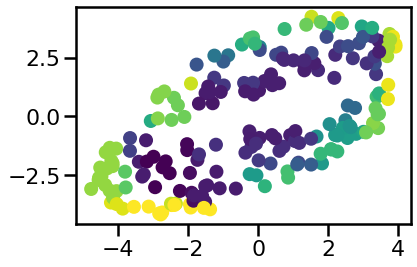

In [81]:
data = test_x1_trans.copy()
label = l2f_task1_pos_trans.copy()
plt.scatter(data[:,0], data[:,1], c=label[:,0])


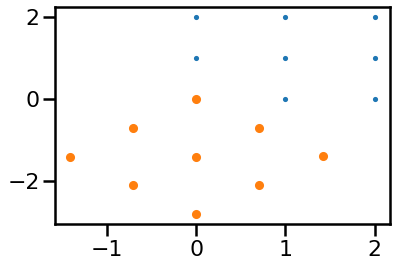

In [68]:
i = np.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]])
plt.scatter(i[:,0], i[:,1], s=10)
j = np.matmul(i, SP.Q_)
plt.scatter(j[:,0], j[:,1], s=50)

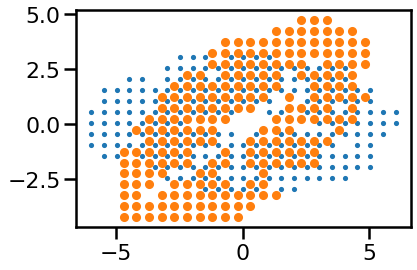

In [66]:
plt.scatter(test_grid1[:,0], test_grid1[:,1], s=10)
plt.scatter(test_grid2[:,0], test_grid2[:,1], s=50)

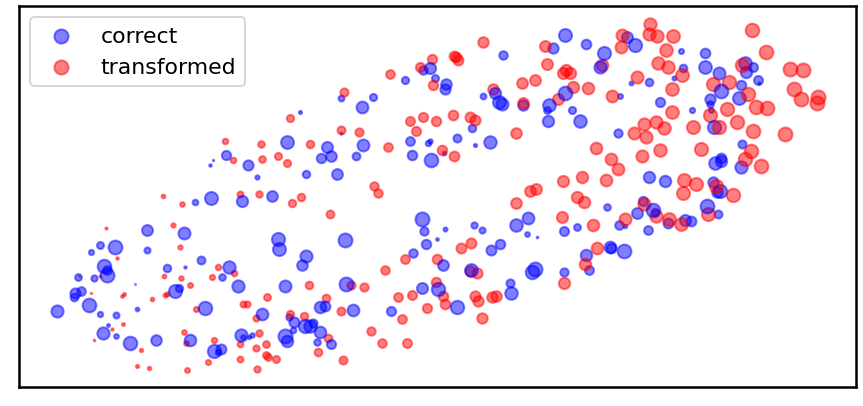

In [82]:
fig,ax = plt.subplots(1, figsize=(15,7))
s = 1
data = [test_x1_trans, test_x2_rot]
# data = [OT.transform(test_grid1), test_grid2]
data_sort = []
idx = np.argsort(data[1][:,0])
for i in range(len(data)):
    data_sort.append(data[i][idx,:])

for i in range(len(data[0])):
    ax.scatter(data_sort[0][i,0], data_sort[0][i,1], s=s, c='b', alpha=0.5, label='correct')
    ax.scatter(data_sort[1][i,0], data_sort[1][i,1], s=s, c='r', alpha=0.5, label='transformed')
#     ax.scatter(test_x2_rot[i,0], test_x2_rot[i,1], s=s, c='b', alpha=0.5, label='correct')
#     ax.scatter(test_x1_new[i,0], test_x1_new[i,1], s=s, c='r', alpha=0.5, label='transformed')
#     ax.scatter(test_grid_ori[i,0], test_grid_ori[i,1], s=s, c='y', alpha=0.2, label='original')
    s += 1
# ax.set_aspect('equal', adjustable='box')
ax.set(yticklabels='', yticks=[], xticklabels='', xticks=[])
# ax.set_title('Nonlinear (45deg) test grid transformed by SP')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
# plt.title('unsupervised sinkhorn transport (affine deg=75)')
plt.show()

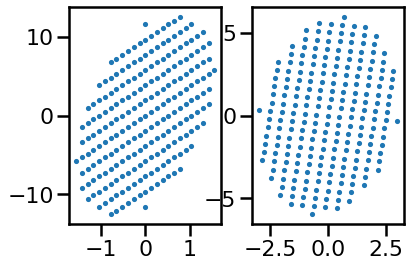

In [104]:
fig,axs = plt.subplots(1,2)
ax = axs[0]
ax.scatter(g[:,0], g[:,1], s=10)
# ax.set_aspect('equal', adjustable='box')
ax = axs[1]
ax.scatter(g_[:,0], g_[:,1], s=10)
# ax.set_aspect('equal', adjustable='box')

In [185]:
angles_all = [[0,15,30,45,60,75,90,105,120,135,150,165,180], 
              [0,15,30,45,60,75,105,120,135,150,165,180],
              [0,15,30,45,60,75,105,120,135,150,165,180]]

def _run(transform, w):
    angles = angles_all[transform]
    errors = np.empty((len(angles), 6))
    for i,angle in enumerate(angles):
        errors[i,:] = exp_reg_pos_asImg_OP(angle, transform, w)
    return errors

rep = 1000
# results_Grid = {}
for t in [1,2]:
    results_Grid[t+2] = Parallel(n_jobs=40, verbose=1)(
        delayed(_run)(t, 3) for _ in range(rep)
    )



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:  4.9min
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:  8.9min
[Parallel(n_jobs=40)]: Done 1000 out of 1000 | elapsed: 11.9min finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:  5.2min
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:  9.8min
[Parallel(n_jobs=40)]: Done 1000 out of 1000 | elapsed: 13.2min finished


In [203]:
np.mean(errors2, axis=0)

NameError: name 'errors2' is not defined

In [204]:
results = {}
r = [np.mean(results_Grid[0], axis=0)]
trans = 0
results[trans] = []
for alg in range(len(r)):
    results[trans].append(error_to_te(r[alg]))

r = [np.mean(results_Grid[1], axis=0)]
trans = 1
results[trans] = []
for alg in range(len(r)):
    results[trans].append(error_to_te(r[alg], 12))

r = [np.mean(results_Grid[2], axis=0)]
trans = 2
results[trans] = []
for alg in range(len(r)):
    results[trans].append(error_to_te(r[alg], 12))

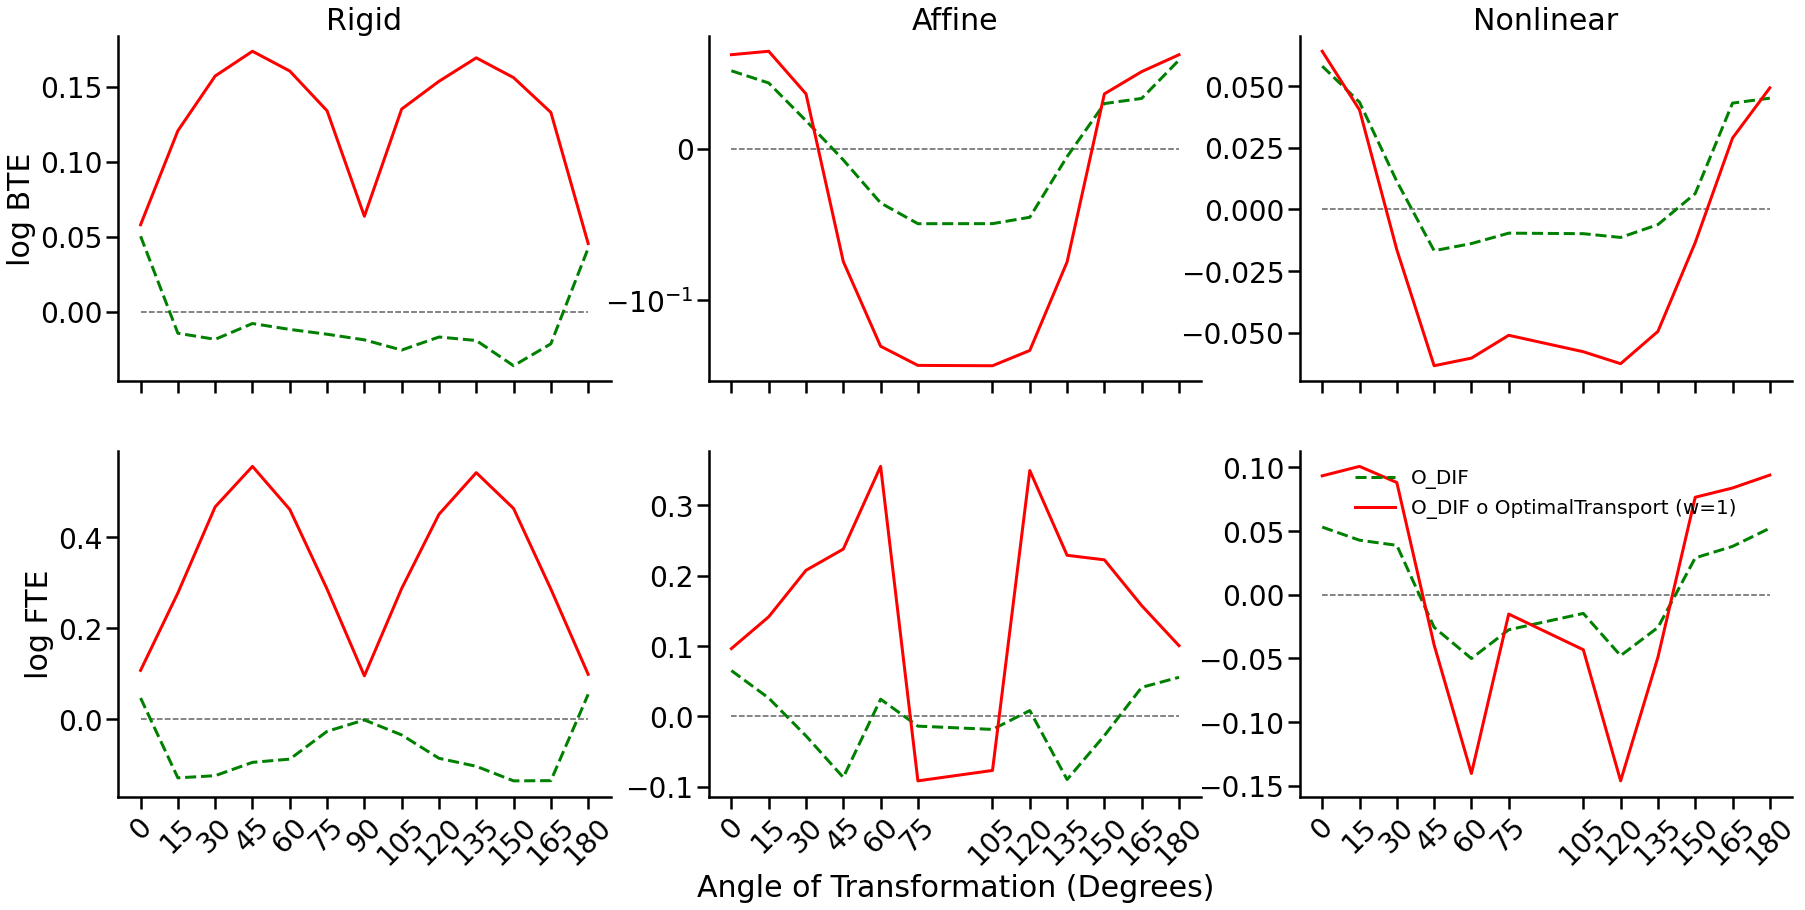

In [205]:
colors = ['g','r','b']
fontsize=30; labelsize=28
fig, axs = plt.subplots(2,3, figsize=(30,14))
angles = [range(0,195,15), [0,15,30,45,60,75,105,120,135,150,165,180], [0,15,30,45,60,75,105,120,135,150,165,180]]
ylabels = ['log BTE','log FTE']
titles = ['Rigid', 'Affine', 'Nonlinear']
labels = ['O_DIF', 'O_DIF o OptimalTransport (w=1)', 'O_DIF o OptimalTransport (w=3)','Pt(OT)','Grid']
line_styles = ['dashed','-','-','-','-']
for i in range(3):
    data = []
    data.append(results[i][0][0].copy())
    for ii in range(len(results[i])):
        data.append(results[i][ii][1].copy())
    for j in range(2):
        ax = axs[j,i]
        for data_idx in range(len(data)):
            ax.plot(
                angles[i], np.log(data[data_idx][j]),label=labels[data_idx],
                lw=3, c=colors[data_idx], ls=line_styles[data_idx]
            )
            ax.set_xticks(angles[i])
            ax.set_xticklabels(angles[i], rotation=45)
            if i == 0:
                ax.set_ylabel(ylabels[j], fontsize=fontsize)
            ax.tick_params(labelsize=labelsize)
            ax.hlines(0, angles[i][0], angles[i][-1], colors='gray', linestyles='dashed',linewidth=1.5)
            right_side = ax.spines["right"]
            right_side.set_visible(False)
            top_side = ax.spines["top"]
            top_side.set_visible(False)
            if j == 0:
                ax.set_xticklabels("")
                ax.set_title(titles[i], fontsize=fontsize)
            else:
                if i == 1:
                    ax.set_xlabel('Angle of Transformation (Degrees)', fontsize=fontsize)
                if i == 2:
                    ax.legend(loc='upper center', fontsize=20, frameon=False)
            if i==1 and j==0:
                ax.set_yscale('symlog', linthresh=0.1)

In [194]:
data

[array([[1.05160892, 0.98568744, 0.98169315, 0.99210514, 0.98820982,
         0.98503563, 0.98134789, 0.97469492, 0.98321037, 0.9809316 ,
         0.9645467 , 0.97876005, 1.04319754],
        [1.0479542 , 0.87965238, 0.88386114, 0.91006075, 0.91654194,
         0.97405632, 0.99877734, 0.96643081, 0.91818569, 0.90221627,
         0.87388899, 0.8742941 , 1.05644694]]),
 array([[1.05967057, 1.12824756, 1.1702284 , 1.18969001, 1.17409949,
         1.14336918, 1.06571487, 1.14470614, 1.16608705, 1.18448938,
         1.16895212, 1.14212348, 1.04646859],
        [1.11341542, 1.31938181, 1.59354513, 1.74132456, 1.58448644,
         1.3305635 , 1.10015962, 1.33239109, 1.56769291, 1.7175218 ,
         1.5878035 , 1.33061726, 1.10376168]]),
 array([[1.05967057, 1.12824756, 1.1702284 , 1.18969001, 1.17409949,
         1.14336918, 1.06571487, 1.14470614, 1.16608705, 1.18448938,
         1.16895212, 1.14212348, 1.04646859],
        [1.11341542, 1.31938181, 1.59354513, 1.74132456, 1.58448644,
       

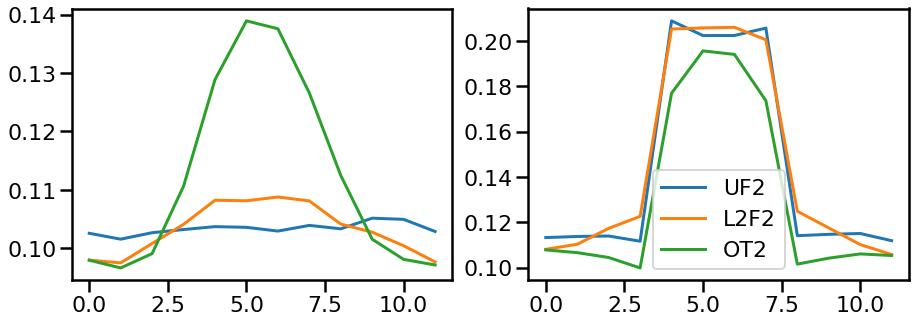

In [103]:
e = np.mean(e1, axis=0)
# r = error_to_te(e, 12)
# id = 1
# plt.plot(np.log(r[0][id]))
# plt.plot(np.log(r[1][id]))
labels = ['UF1','UF2','L2F1','L2F2','OT1','OT2']
fig,axs = plt.subplots(1,2,figsize=(15,5))
for i in [0,2,4]:
    axs[0].plot(e[:,i], label=labels[i])
for i in [1,3,5]:
    axs[1].plot(e[:,i], label=labels[i])
axs[1].legend()

In [113]:
def _exp(angle, transform, n_trees=10, n_samples_source=200):
    [test_x1,test_y1,test_x2_rot,test_y2], l2f, uf =\
        get_data(angle, transform, n_samples_source, n_trees)   
    test_grid_ori, test_grid_trans = to_test_grid(transform, angle)
    
    l2f_task1_pos = generate_posteriors(test_grid_ori, 0, l2f, [0,1])
    l2f_task2_pos = generate_posteriors(test_grid_trans, 1, l2f, [0,1])
    uf_task1_pos = generate_posteriors(test_grid_ori, 0, uf, [0])
    uf_task2_pos = generate_posteriors(test_grid_trans, 1, uf, [1])

    errors = np.zeros(6, dtype=float)
    # L2F
    l2f_pred_task1 = np.mean([l2f_task1_pos[0], l2f_task1_pos[1]], axis=0)
    l2f_task1 = vote_to_pred(l2f_pred_task1[:,0], test_x1, test_grid_ori)
    errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
    l2f_pred_task2 = np.mean([l2f_task2_pos[0], l2f_task2_pos[1]], axis=0)
    l2f_task2 = vote_to_pred(l2f_pred_task2[:,0], test_x2_rot, test_grid_trans)
    errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
    # UF
    uf_task1 = vote_to_pred(uf_task1_pos[0][:,0], test_x1, test_grid_ori)
    errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
    uf_task2 = vote_to_pred(uf_task2_pos[0][:,0], test_x2_rot, test_grid_trans)
    errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)
    
    w = 1
    idx1 = range(len(test_grid_ori))
    idx2 = np.argsort(idx1)
    task1pred1_deformed = vote_to_pred(l2f_task1_pos[0][:,0][idx2], test_x2_rot, test_grid_trans)
    task2pred2_deformed = vote_to_pred(l2f_task2_pos[1][:,0][idx1], test_x1, test_grid_ori)
    OT_task1 = np.average([vote_to_pred(l2f_task1_pos[0][:,0], test_x1, test_grid_ori),
                           task2pred2_deformed], axis=0, weights=[w,1])
    OT_task2 = np.average([vote_to_pred(l2f_task2_pos[1][:,0], test_x2_rot, test_grid_trans),
                           task1pred1_deformed], axis=0, weights=[w,1])

    errors[4] = 1-np.mean(np.argmax(OT_task1, axis=1) == test_y1)
    errors[5] = 1-np.mean(np.argmax(OT_task2, axis=1) == test_y2)

    return errors



In [57]:
errors_Grid = {}
a0 = [0,15,30,45,60,75,90,105,120,135,150,165,180]
a1_2 = [0,15,30,45,60,75,105,120,135,150,165,180]
angle_all = [a0, a1_2, a1_2]
def _run(angles, transform):
    errors = np.empty((len(angles), 6))
    for i,angle in enumerate(angles):
        errors[i,:] = exp_reg_pos_asImg_OP(angle, transform)
    return errors

rep = 1000

for i in range(3):
    errors_Grid[i] = Parallel(n_jobs=40, verbose=1)(
        delayed(_run)(angle_all[i], i) for _ in range(rep)
    )


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:  6.0min
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed: 10.9min
[Parallel(n_jobs=40)]: Done 1000 out of 1000 | elapsed: 14.7min finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:  5.1min
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:  9.6min
[Parallel(n_jobs=40)]: Done 1000 out of 1000 | elapsed: 13.1min finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:  5.2min
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:  9.7min
[Parallel(n_jobs=40)]: Done 1000 out of 1000 | elapsed: 13.2min f

In [70]:
pickle_out = open("store/errors_TE-ellipse-OT-reg-pos-asImg"+".pickle", "wb")
pickle.dump(errors_Grid, pickle_out)
pickle_out.close()

In [72]:
def exp_reg_pos_asPt(angle, transform, alg, n_trees=10, n_samples_source=200):
    [train_x1,tran_x2_rot,test_x1,test_y1,test_x2_rot,test_y2], l2f, uf =\
        get_data(angle, transform, n_samples_source, n_trees)
    
    errors = np.zeros(6, dtype=float)
    uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
    l2f_task1 = l2f.predict(test_x1, task_id=0)
    uf_task2 = uf.predict(test_x2_rot, transformer_ids=[1], task_id=1)
    l2f_task2 = l2f.predict(test_x2_rot, task_id=1)

    # UF
    errors[0] = 1 - np.mean(uf_task1 == test_y1)
    errors[1] = 1 - np.mean(uf_task2 == test_y2)
    # L2F
    errors[2] = 1 - np.mean(l2f_task1 == test_y1)
    errors[3] = 1 - np.mean(l2f_task2 == test_y2)
    
    w = 3; reg = 0.1
    if alg == 'OT':
        ot_sinkhorn = ot.da.SinkhornTransport(reg_e=reg, tol=10e-15)
        ot_sinkhorn.fit(Xs=test_x1, Xt=test_x2_rot)
        idx1 = np.argmax(ot_sinkhorn.coupling_, axis=1)
    elif alg == 'SP':
        SP = SeedlessProcrustes(optimal_transport_lambda=reg, optimal_transport_eps=10e-15,
                           optimal_transport_num_reps=10)
        SP.fit(test_x1, test_x2_rot)
        idx1 = np.argmax(SP.P_, axis=1)
   
    l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_x2_rot, 1, l2f, [0,1])
    idx2 = np.argsort(idx1)
    task1pred1_deformed = l2f_task1[0][idx2]
    task2pred2_deformed = l2f_task2[1][idx1]
    OT_task1 = np.average([l2f_task1[0], task2pred2_deformed], axis=0, weights=[w,1])
    OT_task2 = np.average([l2f_task2[1], task1pred1_deformed], axis=0, weights=[w,1])

    errors[4] = 1-np.mean(np.argmax(OT_task1, axis=1) == test_y1)
    errors[5] = 1-np.mean(np.argmax(OT_task2, axis=1) == test_y2)
#     print(errors)
    
#     tree = BallTree(test_x2_rot)
#     idx1 = tree.query(deformed_x1.reshape((-1,2)), k=1, return_distance=False).reshape((-1,))
    
#     l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
#     l2f_task2 = generate_posteriors(test_x2_rot, 1, l2f, [0,1])
#     idx2 = np.argsort(idx1)
#     task1pred1_deformed = l2f_task1[0][idx2]
#     task2pred2_deformed = l2f_task2[1][idx1]
#     OT_task1 = np.average([l2f_task1[0], task2pred2_deformed], axis=0, weights=[w,1])
#     OT_task2 = np.average([l2f_task2[1], task1pred1_deformed], axis=0, weights=[w,1])

#     errors[4] = 1-np.mean(np.argmax(OT_task1, axis=1) == test_y1)
#     errors[5] = 1-np.mean(np.argmax(OT_task2, axis=1) == test_y2)
    
    return errors

In [174]:
exp_reg_pos_asPt(45,0,'SP')

[0.09  0.115 0.095 0.125 0.085 0.15 ]


array([0.09 , 0.115, 0.095, 0.125, 0.07 , 0.14 ])

In [43]:
# errors_Pt = {}
a0 = [0,15,30,45,60,75,90,105,120,135,150,165,180]
a1_2 = [0,15,30,45,60,75,105,120,135,150,165,180]
def _run(angles, transform, alg):
    errors = np.empty((len(angles), 6))
    for i,angle in enumerate(angles):
        errors[i,:] = exp_reg_pos_asPt(angle, transform, alg)
    return errors

rep = 1000
# algs = ['OT','SP']
algs = ['SP']
for j in range(len(algs)):
    for i in [2]:
        if i == 0:
            errors_Pt[str(i)+'-'+algs[j]] = Parallel(n_jobs=40, verbose=1)(
                delayed(_run)(a0,i,algs[j]) for _ in range(rep)
            )
        else:
            errors_Pt[str(i)+'-'+algs[j]] = Parallel(n_jobs=40, verbose=1)(
                delayed(_run)(a1_2,i,algs[j]) for _ in range(rep)
            )



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:  4.1min
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed: 11.1min
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed: 20.7min
[Parallel(n_jobs=40)]: Done 1000 out of 1000 | elapsed: 28.0min finished


In [309]:
pickle_out = open("store/errors_TE-ellipse-OT-reg-pos-asPt"+".pickle", "wb")
pickle.dump(errors_Pt, pickle_out)
pickle_out.close()

In [68]:
errors_Grid[2] = errors1.copy()

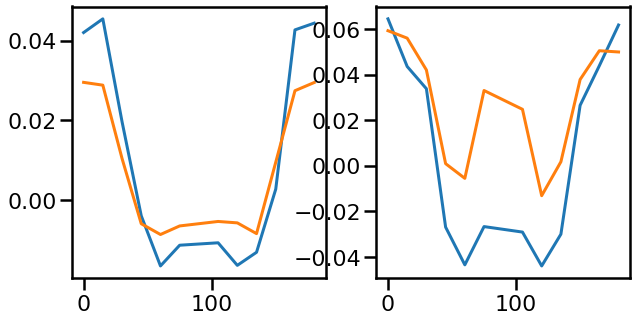

In [69]:
e = np.mean(errors_Grid[2].copy(), axis=0)
r = error_to_te(e, 12)
fig,axs = plt.subplots(1,2, figsize=(10,5))
for i in range(2):
    ax = axs[i]
    ax.plot([0,15,30,45,60,75,105,120,135,150,165,180], np.log(r[0][i]))
    ax.plot([0,15,30,45,60,75,105,120,135,150,165,180], np.log(r[1][i]))

In [138]:
angle=45; n_trees=10; n_samples_source=200; transform=0
angle = np.pi*angle/180
train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
if transform == 0:  # rotation (rigid)
    train_x2_rot = rotate_data(train_x2, angle)
    test_x2_rot = rotate_data(test_x2, angle)
elif transform == 1:  # rotation + shear (affine)
    train_x2_rot = shear_data_rot(train_x2, angle)
    test_x2_rot = shear_data_rot(test_x2, angle)
elif transform == 2:  # double shear (non-linear)
    train_x2_rot,train_y2 = double_shearX(train_x2, train_y2, ss=(np.tan(angle), np.tan(-angle)))
    test_x2_rot,test_y2 = double_shearX(test_x2, test_y2, ss=(np.tan(angle), np.tan(-angle)))

max_depth = ceil(log2(n_samples_source))
l2f = init_forest(max_depth, 2) 
uf = init_forest(max_depth, 2)
l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)

In [75]:
# # L2F
# l2f_task1_pos = generate_posteriors(test_grid, 0, l2f, [0,1])
# l2f_task2_pos = generate_posteriors(test_grid, 1, l2f, [0,1])
# task1pred1_reshaped = reshape_posteriors(inside, l2f_task1_pos[0][:,0])
# task1pred2_reshaped = reshape_posteriors(inside, l2f_task1_pos[1][:,0])
# task2pred1_reshaped = reshape_posteriors(inside, l2f_task2_pos[0][:,0])
# task2pred2_reshaped = reshape_posteriors(inside, l2f_task2_pos[1][:,0])

# uf_task1_pos = generate_posteriors(test_grid, 0, uf, [0])
# uf_task2_pos = generate_posteriors(test_grid, 1, uf, [1])
# task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1_pos[0][:,0])
# task2pred1_reshaped_uf = reshape_posteriors(inside, uf_task2_pos[0][:,0])

# errors = np.zeros(10,dtype=float)
# # L2F
# l2f_pred_task1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside]
# l2f_task1 = vote_to_pred(l2f_pred_task1, test_x1, test_grid)
# errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
# l2f_pred_task2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)[inside]
# l2f_task2 = vote_to_pred(l2f_pred_task2, test_x2_rot, test_grid)
# errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
# # UF
# uf_pred_task1 = task1pred1_reshaped_uf[inside]
# uf_task1 = vote_to_pred(uf_pred_task1, test_x1, test_grid)
# errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
# uf_pred_task2 = task2pred1_reshaped_uf[inside]
# uf_task2 = vote_to_pred(uf_pred_task2, test_x2_rot, test_grid)
# errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)
# print(errors)


[0.07  0.1   0.085 0.1   0.    0.    0.    0.    0.    0.   ]


In [80]:
errors = np.zeros(6, dtype=float)
uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
l2f_task1 = l2f.predict(test_x1, task_id=0)
uf_task2 = uf.predict(test_x2_rot, transformer_ids=[1], task_id=1)
l2f_task2 = l2f.predict(test_x2_rot, task_id=1)

# UF
errors[0] = 1 - np.mean(uf_task1 == test_y1)
errors[1] = 1 - np.mean(uf_task2 == test_y2)
# L2F
errors[2] = 1 - np.mean(l2f_task1 == test_y1)
errors[3] = 1 - np.mean(l2f_task2 == test_y2)
errors

array([0.1  , 0.1  , 0.075, 0.145, 0.   , 0.   ])

In [194]:
test_grid_ori, test_grid_trans = to_test_grid(transform=0, angle=15)

In [183]:
idx = np.arange(len(test_grid_ori))
np.random.shuffle(idx)
test_grid_trans = test_grid_trans[idx,:]

In [210]:
# OP = OrthogonalProcrustes()
# deformed_x1 = OP.fit_transform(test_grid_ori, test_grid_trans)
# OP = OrthogonalProcrustes()
# deformed_x2 = OP.fit_transform(test_grid_trans, test_grid_ori)

SP = SeedlessProcrustes(optimal_transport_lambda=0.1, optimal_transport_eps=10e-15,
                       optimal_transport_num_reps=10)
deformed_x1 = SP.fit_transform(test_grid_ori, test_grid_trans)
deformed_x2 = SP.fit_transform(test_grid_trans, test_grid_ori)

# tree = BallTree(test_grid_trans)
# idx1 = tree.query(deformed_x1.reshape((-1,2)), k=1, return_distance=False).reshape((-1,))

# Sinkhorn Transport
# ot_sinkhorn = ot.da.SinkhornTransport(reg_e=0.1, tol=10e-15)
# ot_sinkhorn.fit(Xs=test_grid_ori, Xt=test_grid_trans)
# deformed_x1 = ot_sinkhorn.transform(Xs=test_grid_ori)
# deformed_x2 = ot_sinkhorn.inverse_transform(Xt=test_grid_trans)
# idx1 = np.argmax(ot_sinkhorn.coupling_, axis=1)

idx2 = np.argsort(idx1)

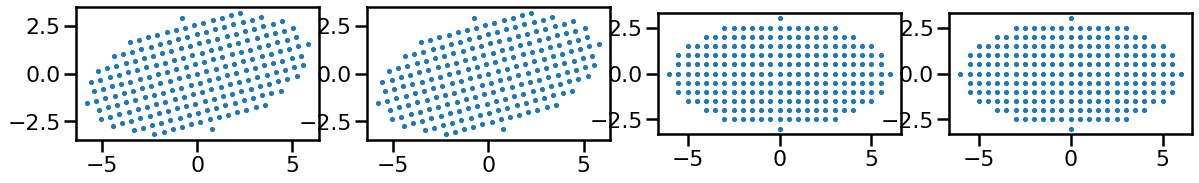

In [211]:
fig,axs = plt.subplots(1,4, figsize=(20,4))
ax = axs[0]
ax.scatter(deformed_x1[:,0], deformed_x1[:,1], s=10)
ax.set_aspect('equal', adjustable='box')
ax = axs[1]
ax.scatter(test_grid_trans[:,0], test_grid_trans[:,1], s=10)
ax.set_aspect('equal', adjustable='box')
ax = axs[2]
ax.scatter(deformed_x2[:,0], deformed_x2[:,1], s=10)
ax.set_aspect('equal', adjustable='box')
ax = axs[3]
ax.scatter(test_grid_ori[:,0], test_grid_ori[:,1], s=10)
ax.set_aspect('equal', adjustable='box')

In [81]:
# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=0.05, tol=10e-15)
ot_sinkhorn.fit(Xs=test_x1, Xt=test_x2_rot)
deformed_x1 = ot_sinkhorn.transform(Xs=test_x1)
deformed_x2 = ot_sinkhorn.inverse_transform(Xt=test_x2_rot)
idx1 = np.argmax(ot_sinkhorn.coupling_, axis=1)

# ot_emd = ot.da.EMDTransport()
# ot_emd.fit(Xs=test_x1, Xt=test_x2_rot)
# deformed_x1 = ot_emd.transform(Xs=test_x1)
# deformed_x2 = ot_emd.inverse_transform(Xt=test_x2_rot)
# idx1 = np.argmax(ot_emd.coupling_, axis=1)

In [63]:
# SP = SeedlessProcrustes()
# deformed_x1 = SP.fit_transform(test_x1, test_x2_rot)
# deformed_x2 = SP.fit_transform(test_x2_rot, test_x1)

# SP = SeedlessProcrustes(optimal_transport_lambda=0.02, optimal_transport_eps=10e-15,
#                        optimal_transport_num_reps=1000)
# deformed_x1 = SP.fit_transform(test_x1, test_x2_rot)
# deformed_x2 = SP.fit_transform(test_x2_rot, test_x1)

# tree = BallTree(test_x2_rot)
# idx1 = tree.query(deformed_x1.reshape((-1,2)), k=1, return_distance=False).reshape((-1,))

In [82]:
l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_x2_rot, 1, l2f, [0,1])

idx2 = np.argsort(idx1)
task1pred1_deformed = l2f_task1[0][idx2]
task2pred2_deformed = l2f_task2[1][idx1]
print(1-np.mean(np.argmax(task2pred2_deformed, axis=1) == test_y1))
print(1-np.mean(np.argmax(task1pred1_deformed, axis=1) == test_y2))
w = 2
OT_task1 = np.average([l2f_task1[0], task2pred2_deformed], axis=0, weights=[w,1])
OT_task2 = np.average([l2f_task2[1], task1pred1_deformed], axis=0, weights=[w,1])

errors[4] = 1-np.mean(np.argmax(OT_task1, axis=1) == test_y1)
errors[5] = 1-np.mean(np.argmax(OT_task2, axis=1) == test_y2)
errors

0.19999999999999996
0.39


array([0.1  , 0.1  , 0.075, 0.145, 0.085, 0.08 ])

In [213]:
# L2F
l2f_task1_pos = generate_posteriors(test_grid_ori, 0, l2f, [0,1])
l2f_task2_pos = generate_posteriors(test_grid_trans, 1, l2f, [0,1])

uf_task1_pos = generate_posteriors(test_grid_ori, 0, uf, [0])
uf_task2_pos = generate_posteriors(test_grid_trans, 1, uf, [1])

errors = np.zeros(6, dtype=float)
# L2F
l2f_pred_task1 = np.mean([l2f_task1_pos[0], l2f_task1_pos[1]], axis=0)
l2f_task1 = vote_to_pred(l2f_pred_task1[:,0], test_x1, test_grid_ori)
errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
l2f_pred_task2 = np.mean([l2f_task2_pos[0], l2f_task2_pos[1]], axis=0)
l2f_task2 = vote_to_pred(l2f_pred_task2[:,0], test_x2_rot, test_grid_trans)
errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
# UF
uf_task1 = vote_to_pred(uf_task1_pos[0][:,0], test_x1, test_grid_ori)
errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
uf_task2 = vote_to_pred(uf_task2_pos[0][:,0], test_x2_rot, test_grid_trans)
errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)
errors

array([0.055, 0.315, 0.035, 0.325, 0.   , 0.   ])

In [217]:
# tree = BallTree(test_grid_trans)
# idx1 = tree.query(deformed_x1.reshape((-1,2)), k=1, return_distance=False).reshape((-1,))
# idx2 = np.argsort(idx1)
task1pred1_deformed = vote_to_pred(l2f_task1_pos[0][:,0][idx2], test_x2_rot, test_grid_trans)
task2pred2_deformed = vote_to_pred(l2f_task2_pos[1][:,0][idx1], test_x1, test_grid_ori)
# print(1-np.mean(np.argmax(task2pred2_deformed, axis=1) == test_y1))
# print(1-np.mean(np.argmax(task1pred1_deformed, axis=1) == test_y2))
w = 2
OT_task1 = np.average([vote_to_pred(l2f_task1_pos[0][:,0], test_x1, test_grid_ori),
                       task2pred2_deformed], axis=0, weights=[w,1])
OT_task2 = np.average([vote_to_pred(l2f_task2_pos[1][:,0], test_x2_rot, test_grid_trans),
                       task1pred1_deformed], axis=0, weights=[w,1])

errors[4] = 1-np.mean(np.argmax(OT_task1, axis=1) == test_y1)
errors[5] = 1-np.mean(np.argmax(OT_task2, axis=1) == test_y2)
errors

array([0.055, 0.315, 0.035, 0.325, 0.03 , 0.305])

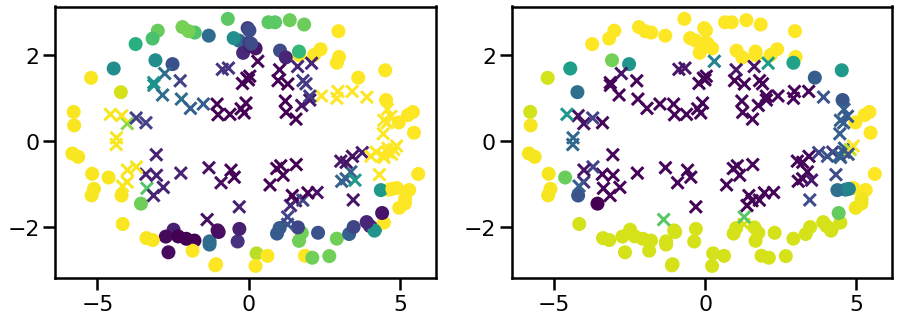

In [89]:
fig,axs = plt.subplots(1,2, figsize=(15,5))
m = ['o','x']
idx = np.where(test_y1 == 0)
axs[0].scatter(test_x1[idx,0], test_x1[idx,1], c=l2f_task2[1][idx1][idx,0],
          marker=m[0])
axs[1].scatter(test_x1[idx,0], test_x1[idx,1], c=l2f_task1[0][idx,0],
          marker=m[0])
idx = np.where(test_y1 == 1)
axs[0].scatter(test_x1[idx,0], test_x1[idx,1], c=l2f_task2[1][idx1][idx,0],
          marker=m[1])
axs[1].scatter(test_x1[idx,0], test_x1[idx,1], c=l2f_task1[0][idx,0],
          marker=m[1])

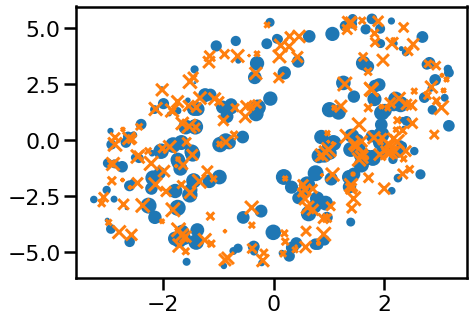

In [93]:
fig,ax = plt.subplots(1, figsize=(7,5))
idx = np.argsort(test_y2)
ax.scatter(test_x2_rot[idx,0], test_x2_rot[idx,1], s=range(len(test_x1)), marker='o')
ax.scatter(deformed_x1[idx,0], deformed_x1[idx,1], s=idx2[idx], marker='x')

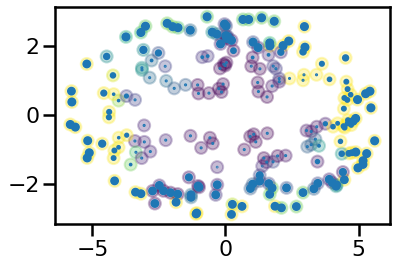

In [69]:
plt.scatter(test_x1[:,0], test_x1[:,1], c=l2f_task2[1][idx1][:,0], alpha=0.3)
plt.scatter(test_x1[:,0], test_x1[:,1], s=l2f_task1[0][:,0]*50)

In [71]:
idx1 = np.argmax(ot_sinkhorn.coupling_, axis=1)
idx2 = np.argsort(idx1)
np.vstack((np.argmax(l2f_task2[1][idx1],axis=1), np.argmax(l2f_task1[0],axis=1)))

array([[1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1],
       [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 

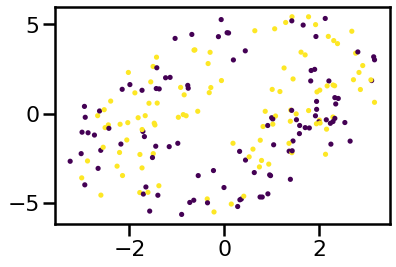

In [22]:
# plt.scatter(test_x1[:,0], test_x1[:,1],
#                  c=np.argmax(task2pred2_deformed, axis=1), s=10)
plt.scatter(test_x2_rot[:,0], test_x2_rot[:,1],
                 c=np.argmax(task1pred1_deformed, axis=1), s=10)

In [433]:
s = np.array([[1,0],[2,0],[0,0]])
t = np.array([[3,3],[0,0],[1,1]])
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=.1, tol=10e-11)
ot_sinkhorn.fit(Xs=s, Xt=t)

# transport source samples onto target samples
deformed_x1 = ot_sinkhorn.transform(Xs=s)
deformed_x2 = ot_sinkhorn.inverse_transform(Xt=t)
print(deformed_x1)
print(deformed_x2)

[[9.99952763e-01 9.99952763e-01]
 [2.99991661e+00 2.99991661e+00]
 [4.36303532e-05 4.36303532e-05]]
[[2.00000000e+00 0.00000000e+00]
 [4.72368146e-05 0.00000000e+00]
 [9.99998065e-01 0.00000000e+00]]


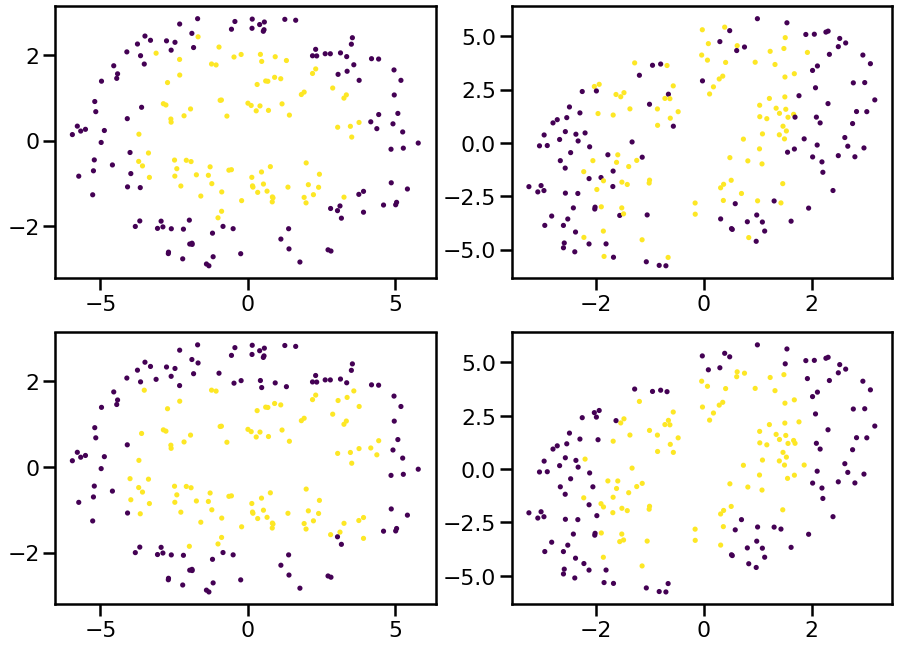

In [445]:
fig, axs = plt.subplots(2,2, figsize=(15,11))
axs[0,0].scatter(test_x1[:,0], test_x1[:,1],
            c=np.argmax(OT_task1, axis=1), s=10)
axs[0,1].scatter(test_x2_rot[:,0], test_x2_rot[:,1],
            c=np.argmax(OT_task2, axis=1), s=10)
axs[1,0].scatter(test_x1[:,0], test_x1[:,1],
            c=np.argmax(np.mean([l2f_task1[0], l2f_task1[1]], axis=0),
                        axis=1), s=10)
axs[1,1].scatter(test_x2_rot[:,0], test_x2_rot[:,1],
            c=np.argmax(np.mean([l2f_task2[1], l2f_task2[0]], axis=0),
                        axis=1), s=10)